In [1]:
%cd '/home/vri/Projects/research/Flood-detection'

/home/vri/Projects/research/Flood-detection


In [2]:
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import numpy as np 

import subprocess
from subprocess import PIPE

import rasterio
import cv2
from rasterio.plot import show

import torch
import torchvision
from torch import nn 
from torchvision import transforms as T
import torch.utils.data as data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
from utils import utils_dirs

In [4]:
def is_empty_img (path):
    """ 
    Function to check if image is empty (0-filled file)

    Args:
        path (path.path): path to image subfolder

    Returns:
        bool
    """
    img = cv2.imread (path + '/B01.tif', 1)
    return True if (cv2.countNonZero(img) == 0) else False

In [5]:
def remove_empty_folders(path):
    """function to remove empty image subfolders (subfolders with no spectral band data)

    Args:
        path (path.path) : path to image subfolder
    """
    subprocess.run(['rm', '-r', path])
    return

In [6]:
def stack_bands(path, dirname, bands):
    """
    function to stack different spectral bands.
    For the scope of this project, the selected bands are: 2, 3, 4, 8 (B, G, R, Near-infrared)

    Args:
        path (path.path): path to image subfolder
        bands (list): list of bands to be stacked together.
    """
    
    try:
        with rasterio.open(f"{path}/{bands[0]}") as src0:
            meta = src0.meta
        meta.update(count = len(bands))

        with rasterio.open(f"{path}/stack.tif", 'w', **meta) as dst:
            for id, layer in enumerate(bands, start=1):
                with rasterio.open(f"{path}/{layer}") as src1:
                    dst.write_band(id, src1.read(1))
    
    except:
        print(f"{dirname} is an empty folder")
        remove_empty_folders(path)

        pass


    # --------------------

    # arrs = []
    # try:
    #     for band in bands:
    #         band_path = os.path.join(path, band)
    #         with rasterio.open(band_path) as f:
    #             arrs.append(f.read(1))
    #     img = np.array(arrs, astype = arrs[0].dtype)

    #     with rasterio.open(f"{path}/{bands[0]}") as src0:
    #         meta = src0.meta
    #     meta.update(count = len(bands))

    #     with rasterio.open(f"{path}/stacked.tif", "w", **meta) as dst:
    #         dst.write_band(1, img.astype('uint8'))
    # except:
    #     print(f"{dirname} is an empty folder")
    #     remove_empty_folders(path)

    #     pass


# band_list = ['B02.tif' , 'B03.tif' , 'B04.tif']

band_list = ['B02.tif' , 'B03.tif' , 'B04.tif' , 'B08.tif']

In [7]:
def get_dirname(path):
    """function to retrieve dirname of image subfolder

    Args:
        path (path.path): path to image subfolder

    Returns:
        data['id'] (string): dirname of image subfolder
    """
    json_data = open (f"{path}/stac.json", "rb")
    data = json.load (json_data)

    return data['id']

In [8]:
ROOT_DIR = './data/transformer_data/sen12floods_s2_source'

def get_img_folders(flag:str, root_path = ROOT_DIR):
    """iterate through root folder to get image subfolders

    Args:
        root_path (path.path): path to root directory. Defaults to ROOT_DIR.
    """
    folders_list = []
    for file in os.listdir(root_path):
        d = os.path.join(root_path, file)
        if os.path.isdir(d):
            folders_list.append(d)
    print(f"The number of {flag} image subfolders are: {len(folders_list)}")
    return folders_list

In [9]:
def create_image(flist, bands):
    """function call for deleting empty subfolders, stacking bands and creating new image files for further processing

    Args:
        flist (lsit): liat of image subfolders
    """
    for fpath in flist:
        empty = is_empty_img(fpath)
        remove_empty_folders(fpath) if empty else stack_bands(fpath, get_dirname(fpath), bands)


In [10]:
# CAUTION !! DONT RUN ACCIDENTALLY


# def extract_tar(SOURCE_DIR, SAVE_DIR):
#     """function to extract data from a tar.gz file

#     Args:
#         SOURCE_DIR (path.path): path of tar file
#         SAVE_DIR (path.path): path to save extracted data
#     """
#     SOURCE_DIR = tarfile.open(SOURCE_DIR)
#     SOURCE_DIR.extractall(SAVE_DIR)
#     SOURCE_DIR.close()


# source ='./data/sen12floods_s2_source.tar.gz'
# save = './data/transformer_data'

# extract_tar(source, save)

In [11]:
band_list = ['B02.tif' , 'B03.tif' , 'B04.tif', 'B08.tif']
ROOT_DIR = '/home/vri/Projects/research/Flood-detection/data/transformer_data/sen12floods_s2_source'

flist = utils_dirs.get_img_folders(flag='total', root_path = ROOT_DIR)
utils_dirs.create_image(flist, band_list)

actual_flist = utils_dirs.get_img_folders(flag='valid', root_path = ROOT_DIR)

The number of total image subfolders are: 1949
The number of valid image subfolders are: 1949


In [12]:
def get_image_labels(dirname, label_dir):
    """function to get image label for corresponding image dir

    Args:
        dirname (str): name of image subdirectory
        label_dir (path.path): path to label directory
    """
    pd = dirname.split("_")
    pd = f"{pd[0]}_{pd[1]}_labels_{pd[3]}_{pd[4]}_{pd[5]}_{pd[6]}"

    json_data = open (f"{label_dir}/{pd}/stac.json", "rb")
    jdata = json.load(json_data)
    flood = jdata["properties"]["FLOODING"]

    image_label = 1 if flood else 0

    return image_label


In [13]:
class CustomDataset(Dataset):

    def __init__(self, img_list, label_path, transform = None ):
        self.transform = transform
        self.img_list = img_list
        self.label_path = label_path
        

    def __getitem__(self, idx):
        img_name = get_dirname(self.img_list[idx])
        label = get_image_labels(img_name, self.label_path)

        img = cv2.imread(f"{self.img_list[idx]}/stack.tif")
        if self.transform:
            img = self.transform(img)
            # label = self.transform(label)
        
        return img,label
    
    def __len__(self):
        return len(self.img_list)

In [14]:
BATCH_SIZE = 64
MEAN, STD=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
device ='cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
data_transforms = T.Compose([
    T.ToTensor() ,
    T.Normalize(MEAN, STD)
])

In [36]:
LABEL_PATH = './data/transformer_labels/sen12floods_s2_labels'

In [37]:
total_dataset = CustomDataset(actual_flist, LABEL_PATH, data_transforms)

In [38]:
len(total_dataset)

1949

In [39]:
train_size = int(0.85 * len(total_dataset))
test_size = len(total_dataset) - train_size

train_set , test_set = random_split(total_dataset, [train_size, test_size])

In [40]:
len(train_set)

1656

In [41]:
device

'cuda'

In [42]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [43]:
len(train_set), len(test_set)


(1656, 293)

In [44]:
train_set[1][1]

1

In [45]:
next(iter(test_loader))[0].shape

torch.Size([64, 3, 512, 512])

In [47]:
def plot_images(dataloader, num_images=16):
    """
    function for easy visualisation of images from dataset.
    args:
        dataloader: a pytorch dataloader object
        num_images: number of images to be plotted
    """
    
    # Get a batch of images from the dataloader
    data = next(iter(dataloader))
    images, _ = data
    images = [img[[2,1,0],:,:] for img in images]

    # sent_img[[2,1,0], :, :]/np.amax(sent_img)
        

    # Generate a grid of images
    img_grid = vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True)

    # Convert the image grid to a numpy array and transpose the dimensions
    img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

    # Plot the image grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(img_grid)
    plt.title("Sample Images")
    plt.show()

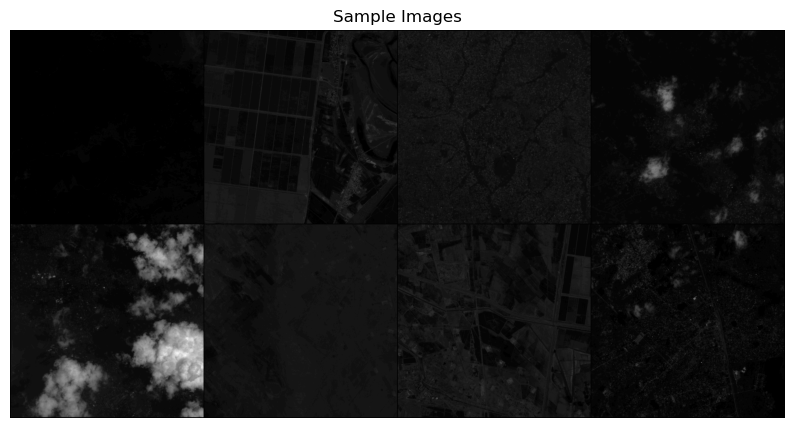

In [49]:
plot_images(train_loader, num_images=8)